# Mount Drive

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Needed Libraries

In [17]:
!pip install tifffile
import tifffile as tiff
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 18.5 MB/s eta 0:00:00


In [11]:
!pip install gradio

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import glob
from PIL import Image
import cv2
from collections import Counter
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Input,Conv2DTranspose,Dropout,BatchNormalization,Activation,concatenate
from tensorflow.keras import Model
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from sklearn.metrics import confusion_matrix,classification_report
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
import gradio as gr
import shutil
import rasterio
from sklearn.model_selection import train_test_split
import pywt
from skimage.filters.rank import entropy
from skimage.morphology import disk

# Explore the Data

In [13]:
img_size=256

In [14]:
img_dir = '/content/drive/MyDrive/filtered/images'
mask_dir = '/content/drive/MyDrive/filtered/masks'

In [15]:
print(len(os.listdir(img_dir)))
print(len(os.listdir(mask_dir)))

306
306


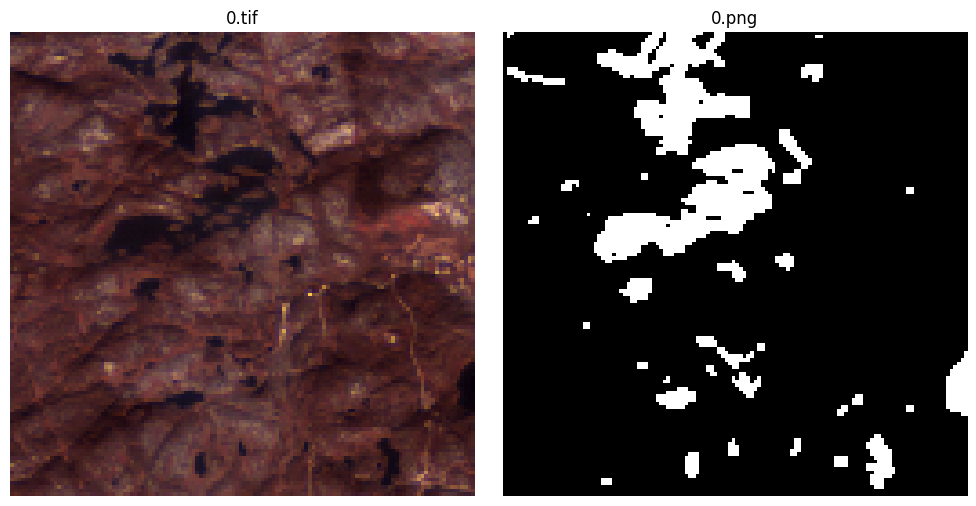

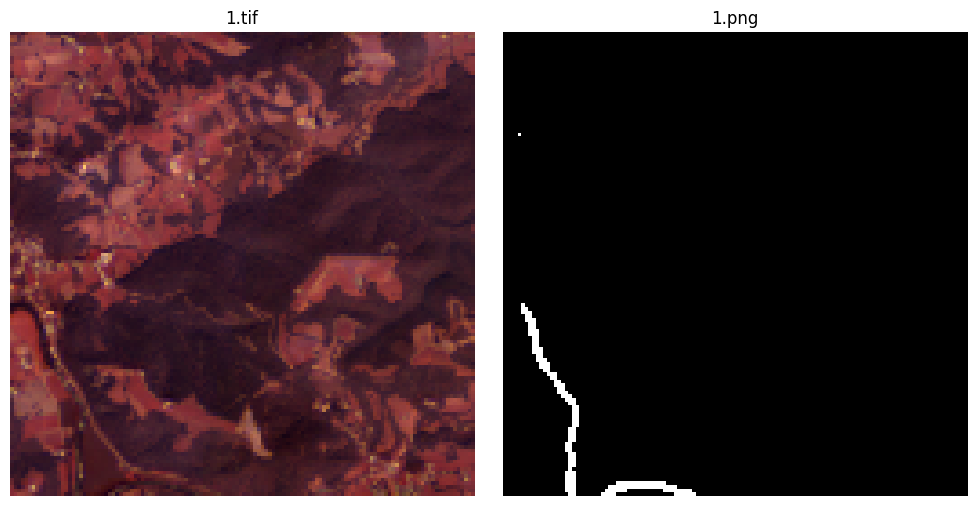

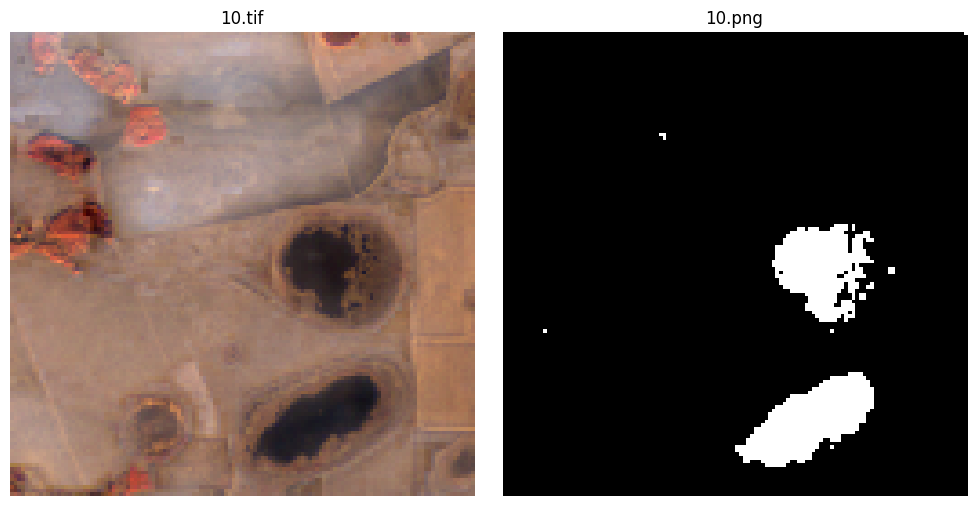

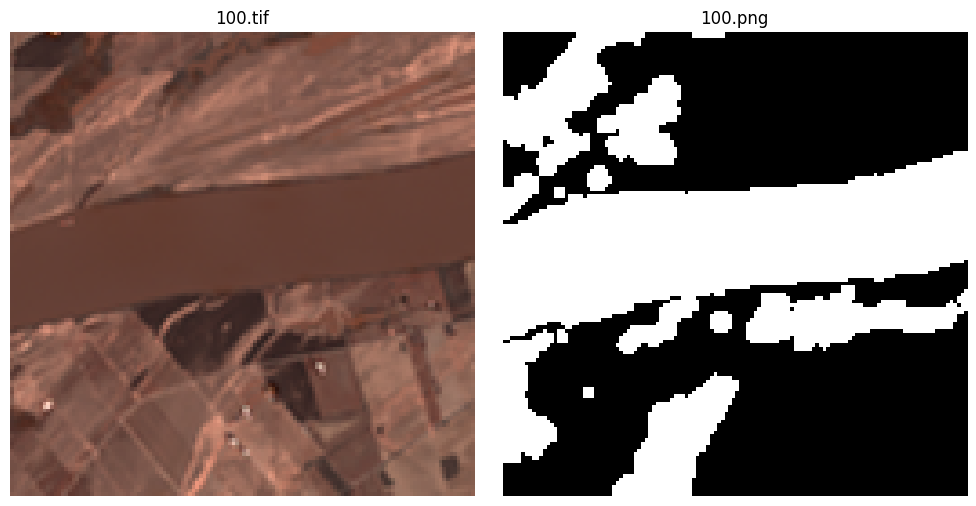

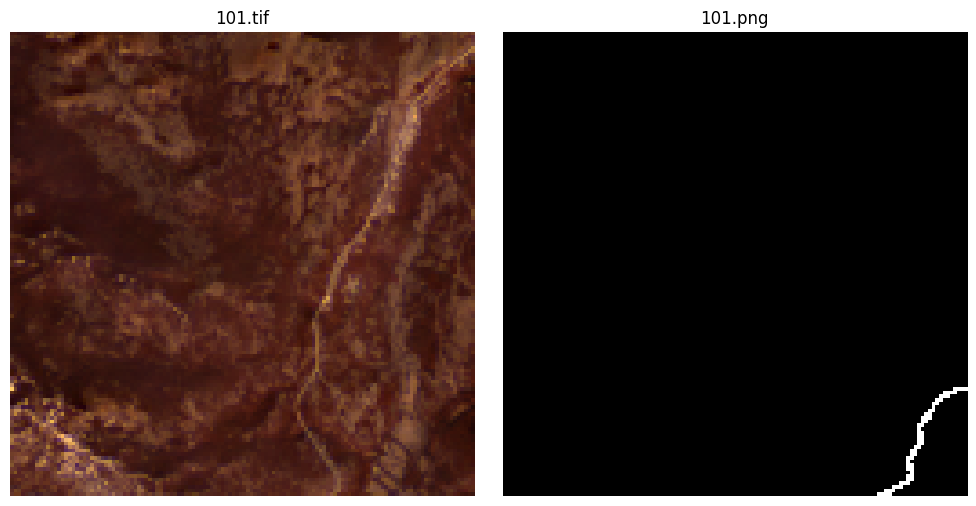

In [20]:
def show_sample(image_path, mask_path):
    # Load the .tif image (satellite)
    image = tiff.imread(image_path)

    # If image is (12, H, W), convert to (H, W, 12)
    if image.ndim == 3 and image.shape[0] == 12:
        image = np.transpose(image, (1, 2, 0))

    # Pick RGB bands (commonly [2,1,0] = R,G,B)
    rgb_image = image[:, :, [2, 1, 0]]

    # Normalize for visualization
    rgb_image = rgb_image.astype(np.float32)
    rgb_image -= rgb_image.min()
    rgb_image /= rgb_image.max()

    # Load the mask (assumed .png)
    mask = Image.open(mask_path)
    mask = np.array(mask)

    # Plot both
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title(image_path.split('/')[-1])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(mask_path.split('/')[-1])
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Pick any 3 samples
image_files = sorted(os.listdir(img_dir))[:5]
mask_files = sorted(os.listdir(mask_dir))[:5]

for image_file, mask_file in zip(image_files, mask_files):
    image_path = os.path.join(img_dir, image_file)
    mask_path = os.path.join(mask_dir, mask_file)
    show_sample(image_path, mask_path)

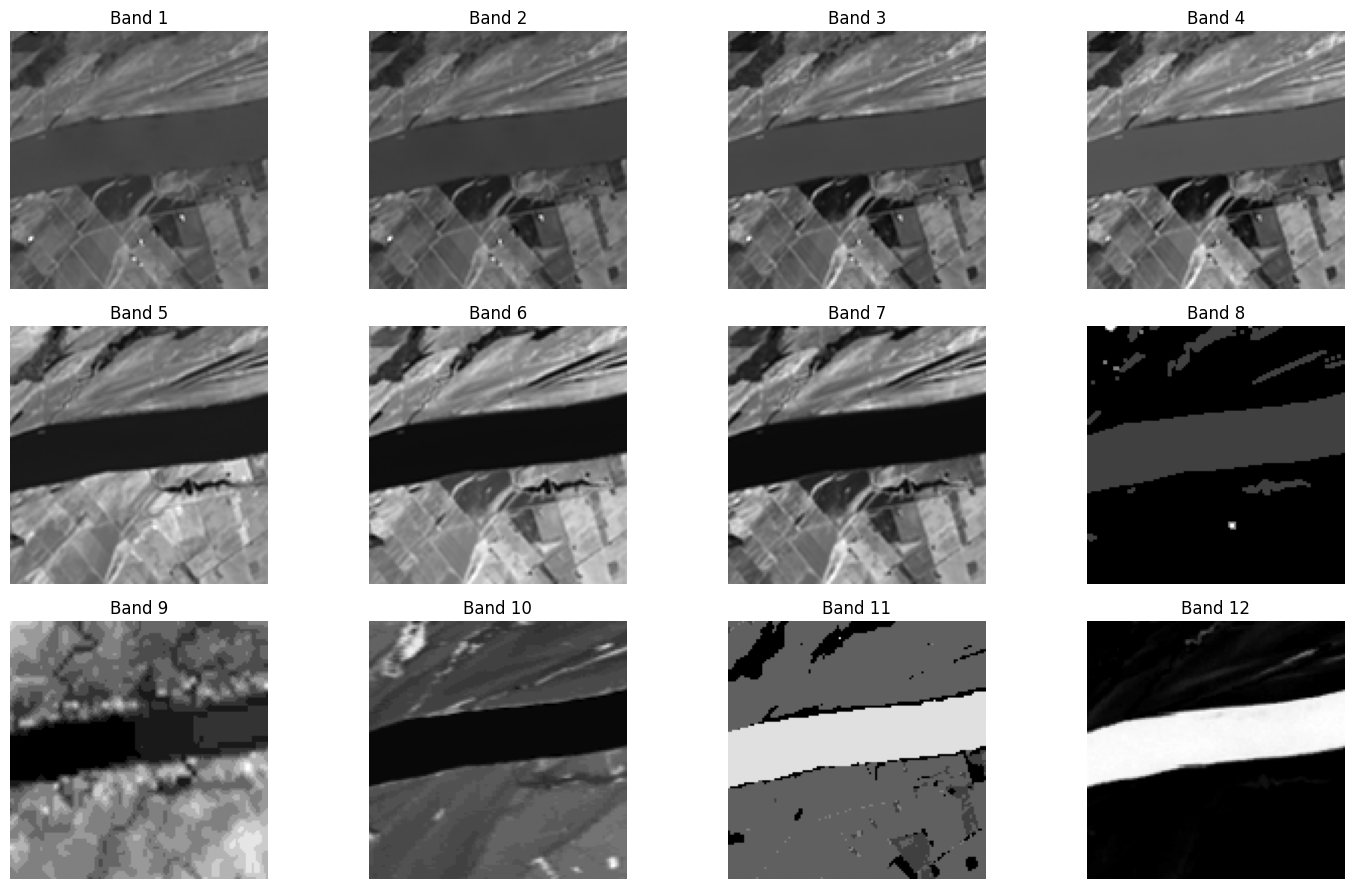

In [66]:
image_path = '/content/drive/MyDrive/filtered/images/100.tif'
with rasterio.open(image_path) as src:
    img = src.read()  # shape: (bands, height, width)

# Get number of bands
num_bands = img.shape[0]

# Plot each band
cols = 4
rows = (num_bands + cols - 1) // cols  # auto-calculate rows
fig, axs = plt.subplots(rows, cols, figsize=(15, 3 * rows))

for i in range(rows * cols):
    ax = axs[i // cols, i % cols]
    if i < num_bands:
        ax.imshow(img[i], cmap='gray')
        ax.set_title(f'Band {i+1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


File: /content/drive/MyDrive/filtered/images/100.tif
Number of bands: 12
Shape: 128 x 128
CRS: None
Resolution: (1.0, 1.0)
Descriptions: (None, None, None, None, None, None, None, None, None, None, None, None)
Dtype: ('int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16', 'int16')
Indexes: (1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12)
Normalized data shape: (12, 128, 128)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


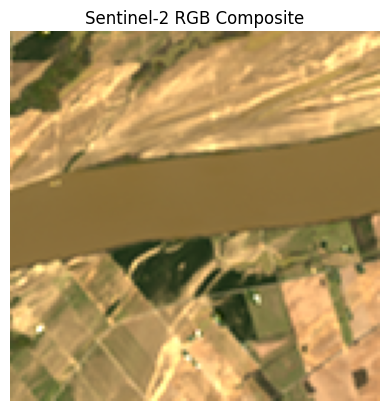

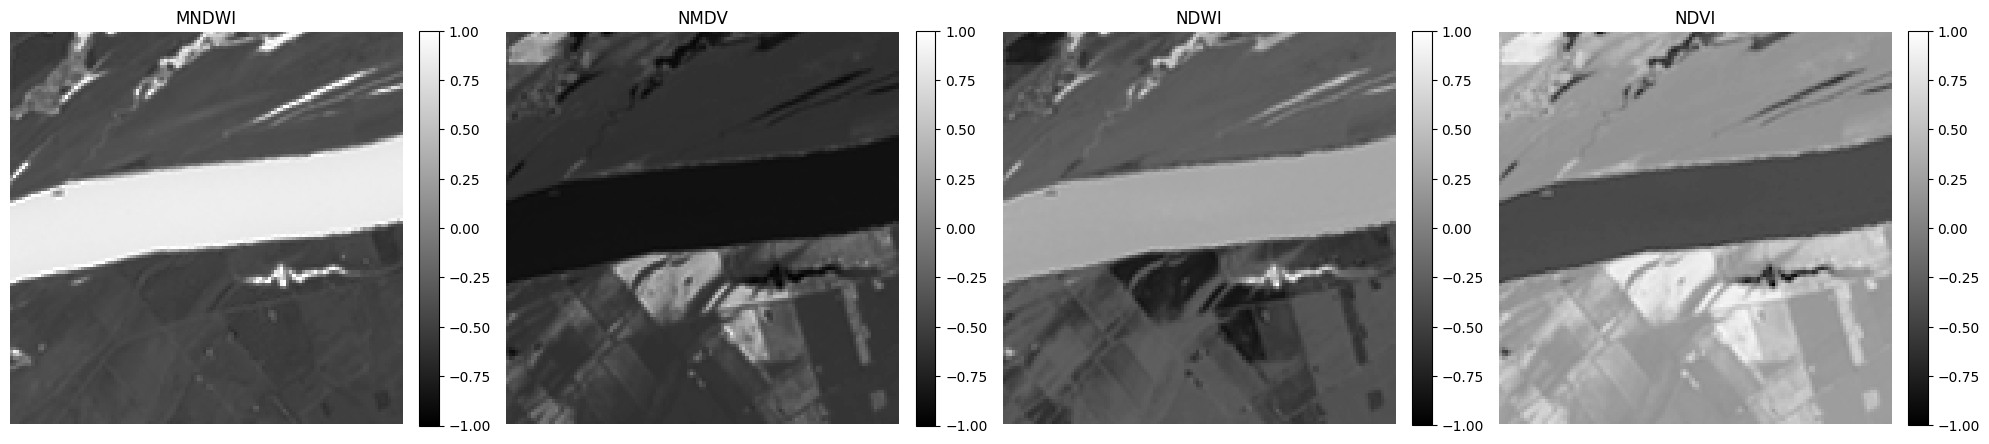

In [84]:
tif_path = "/content/drive/MyDrive/filtered/images/100.tif"

with rasterio.open(tif_path) as src:
    image = src.read()
    print(f"File: {tif_path}")
    print(f"Number of bands: {src.count}")
    print(f"Shape: {src.height} x {src.width}")
    print(f"CRS: {src.crs}")
    print("Resolution:", src.res)
    print(f"Descriptions: {src.descriptions}")
    print(f"Dtype: {src.dtypes}")
    print(f"Indexes: {src.indexes}")

normalized = np.empty_like(image, dtype=np.float32)
unnormalized = np.empty_like(image, dtype=np.float32)

for i in range(image.shape[0]):
    band = image[i]
    if i == 0:
        normalized[i] = band / 10000.0
    elif i in [1,2,3]:
        normalized[i] = band / 255.0
    elif i in [4,5,6]:
        normalized[i] = band / 1000.0
        unnormalized[i]=band/255.0
    elif i == 7:
        normalized[i] = band.astype(np.float16)
    elif i in [8, 9]:
        normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
    elif i == 10:
        normalized[i] = band.astype(np.float16)
    elif i == 11:
        normalized[i] = band / 100.0

print("Normalized data shape:", normalized.shape)

rgb = np.stack([
    normalized[3],
    normalized[2],
    normalized[1],
], axis=-1)
mndwi = (normalized[2] - unnormalized[5]) / (normalized[2] + unnormalized[5] + 1e-6)
ndwi = (normalized[2] - unnormalized[4]) / (normalized[2] + unnormalized[4] + 1e-6)
ndvi = (unnormalized[4] - normalized[3]) / (unnormalized[4] + normalized[3] + 1e-6)
ndti  = (normalized[5] - normalized[6]) / (normalized[5] + normalized[6] + 1e-6)
nmdv = (normalized[4] - (normalized[3] + normalized[1])) / (normalized[4] + normalized[3] + normalized[1] + 1e-6)
nmdv = np.clip(nmdv, -1, 1)
mndwi = np.clip(mndwi, -1, 1)
ndwi = np.clip(ndwi, -1, 1)
ndvi = np.clip(ndvi, -1, 1)
spect = np.stack([mndwi, nmdv, ndwi, ndvi, ndwi], axis=-1)
rgb /= np.percentile(rgb, 98)
rgb = np.clip(rgb, 0, 1)
plt.imshow(rgb)
plt.title("Sentinel-2 RGB Composite")
plt.axis("off")
plt.show()

titles = ['MNDWI', 'NMDV','NDWI', 'NDVI', 'NDWI']
fig, axs = plt.subplots(1, 4, figsize=(20, 10))

for i, ax in enumerate(axs):
    im = ax.imshow(spect[..., i], cmap='gray', vmin=-1, vmax=1)
    ax.set_title(titles[i])
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

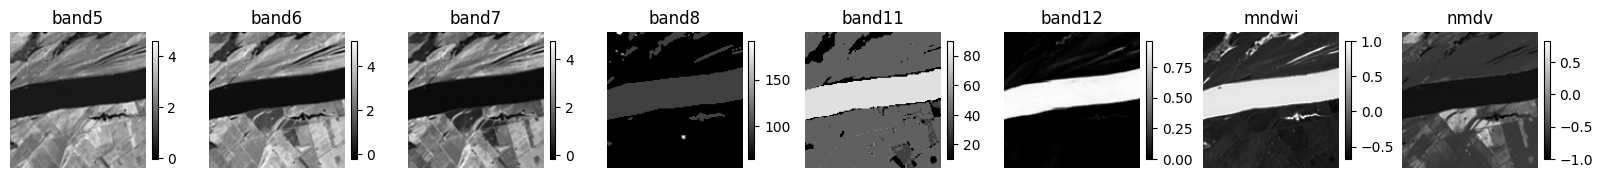

In [87]:
def stack_selected_bands(tif_path):
    with rasterio.open(tif_path) as src:
        image = src.read().astype(np.float32)  # shape: (bands, H, W)

    normalized = np.empty_like(image, dtype=np.float32)
    unnormalized = np.empty_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
      band = image[i]
      if i == 0:
          normalized[i] = band / 10000.0
      elif i in [1,2,3]:
          normalized[i] = band / 255.0
      elif i in [4,5,6]:
          normalized[i] = band / 1000.0
          unnormalized[i]=band/255.0
      elif i == 7:
          normalized[i] = band.astype(np.float16)
      elif i in [8, 9]:
          normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
      elif i == 10:
          normalized[i] = band.astype(np.float16)
      elif i == 11:
          normalized[i] = band / 100.0

    mndwi = (normalized[2] - unnormalized[5]) / (normalized[2] + unnormalized[5] + 1e-6)
    nmdv = (normalized[4] - (normalized[3] + normalized[1])) / (normalized[4] + normalized[3] + normalized[1] + 1e-6)
    nmdv = np.clip(nmdv, -1, 1)
    mndwi = np.clip(mndwi, -1, 1)

    spect = np.stack([normalized[4],normalized[5],normalized[6],normalized[7],normalized[10],normalized[11],mndwi, nmdv], axis=-1)

    return spect


def visualize_water_indices(indices):
    names = ['band5', 'band6', 'band7', 'band8', 'band11','band12', 'mndwi', 'nmdv']
    plt.figure(figsize=(16, 4))

    for i in range(indices.shape[-1]):
        plt.subplot(1, 8, i + 1)
        plt.imshow(indices[:, :, i], cmap='gray')
        plt.colorbar(fraction=0.04, pad=0.04)
        plt.title(names[i])
        plt.axis('off')

    plt.tight_layout()
    plt.show()

image = '/content/drive/MyDrive/filtered/images/100.tif'

# Compute indices
indices = stack_selected_bands(image)

# Visualize them
visualize_water_indices(indices)

# Data Generator

In [69]:
image_paths = [os.path.join(img_dir, file) for file in os.listdir(img_dir)]
mask_paths = [os.path.join(mask_dir, file) for file in os.listdir(mask_dir)]

train_img_paths, val_img_paths, train_mask_paths, val_mask_paths = train_test_split(
    image_paths, mask_paths, test_size=0.2, random_state=42
)

In [97]:
def compute_advanced_features(image):
    features = []
    for i in range(image.shape[-1]):
        band = image[..., i]

        # Gradient (Sobel)
        grad_x = cv2.Sobel(band, cv2.CV_32F, 1, 0, ksize=3)
        grad_y = cv2.Sobel(band, cv2.CV_32F, 0, 1, ksize=3)
        magnitude = np.sqrt(grad_x**2 + grad_y**2)

        # Laplacian
        lap = cv2.Laplacian(band, cv2.CV_32F, ksize=3)

        # Wavelet (Haar)
        coeffs = pywt.dwt2(band, 'haar')
        cA, (cH, cV, cD) = coeffs
        cH_resized = cv2.resize(cH, (band.shape[1], band.shape[0]))
        cV_resized = cv2.resize(cV, (band.shape[1], band.shape[0]))
        cD_resized = cv2.resize(cD, (band.shape[1], band.shape[0]))

        # Entropy
        band_uint8 = cv2.normalize(band, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        entropy_img = entropy(band_uint8, disk(3))

        features.extend([magnitude, lap, cH_resized, cV_resized, cD_resized, entropy_img])
    return np.stack(features, axis=-1)  # Shape: (H, W, num_bands * 6)

def stack_selected_bands(tif_path):
    with rasterio.open(tif_path) as src:
        image = src.read().astype(np.float32)  # (bands, H, W)
    normalized = np.empty_like(image, dtype=np.float32)
    unnormalized = np.empty_like(image, dtype=np.float32)

    for i in range(image.shape[0]):
        band = image[i]
        if i == 0:
            normalized[i] = band / 10000.0
        elif i in [1, 2, 3]:
            normalized[i] = band / 255.0
        elif i in [4, 5, 6]:
            normalized[i] = band / 1000.0
            unnormalized[i] = band / 255.0
        elif i == 7:
            normalized[i] = band.astype(np.float16)
        elif i in [8, 9]:
            normalized[i] = (band - band.min()) / (band.max() - band.min() + 1e-5)
        elif i == 10:
            normalized[i] = band.astype(np.float16)
        elif i == 11:
            normalized[i] = band / 100.0

    mndwi = (normalized[2] - unnormalized[5]) / (normalized[2] + unnormalized[5] + 1e-6)
    nmdv = (normalized[4] - (normalized[3] + normalized[1])) / (normalized[4] + normalized[3] + normalized[1] + 1e-6)
    mndwi = np.clip(mndwi, -1, 1)
    nmdv = np.clip(nmdv, -1, 1)

    stacked = np.stack([
        normalized[4], normalized[5], normalized[6], normalized[7],
        normalized[10], normalized[11], mndwi, nmdv
    ], axis=-1)  # (H, W, 8)

    advanced = compute_advanced_features(stacked)  # (H, W, 8*6=48)

    # Keep only the first 17 advanced features to make total 25 channels
    full = np.concatenate([stacked, advanced[..., :17]], axis=-1)  # (H, W, 25)

    return full


class SentinelSegmentationGenerator(tf.keras.utils.Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=8, shuffle=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def on_epoch_end(self):
        self.indices = np.arange(len(self.image_paths))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        batch_images = [self.image_paths[i] for i in batch_indices]
        batch_masks = [self.mask_paths[i] for i in batch_indices]

        X = [stack_selected_bands(img_path) for img_path in batch_images]
        y = [self.load_mask(mask_path) for mask_path in batch_masks]

        return np.stack(X, axis=0), np.stack(y, axis=0)

    def load_mask(self, mask_path):
        with rasterio.open(mask_path) as src:
            mask = src.read(1)
        mask = mask.astype(np.uint8)
        return np.expand_dims(mask, axis=-1)  # shape: (H, W, 1)


In [102]:
train_generator = SentinelSegmentationGenerator(train_img_paths, train_mask_paths, batch_size=8)
val_generator = SentinelSegmentationGenerator(val_img_paths, val_mask_paths, batch_size=8, shuffle=False)

In [113]:
x_batch, y_batch = train_generator[10]
print("Input shape:", x_batch.shape)  # Expect (8, H, W, 25)
print("Mask shape:", y_batch.shape)   # Expect (8, H, W, 1)

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Input shape: (8, 128, 128, 25)
Mask shape: (8, 128, 128, 1)


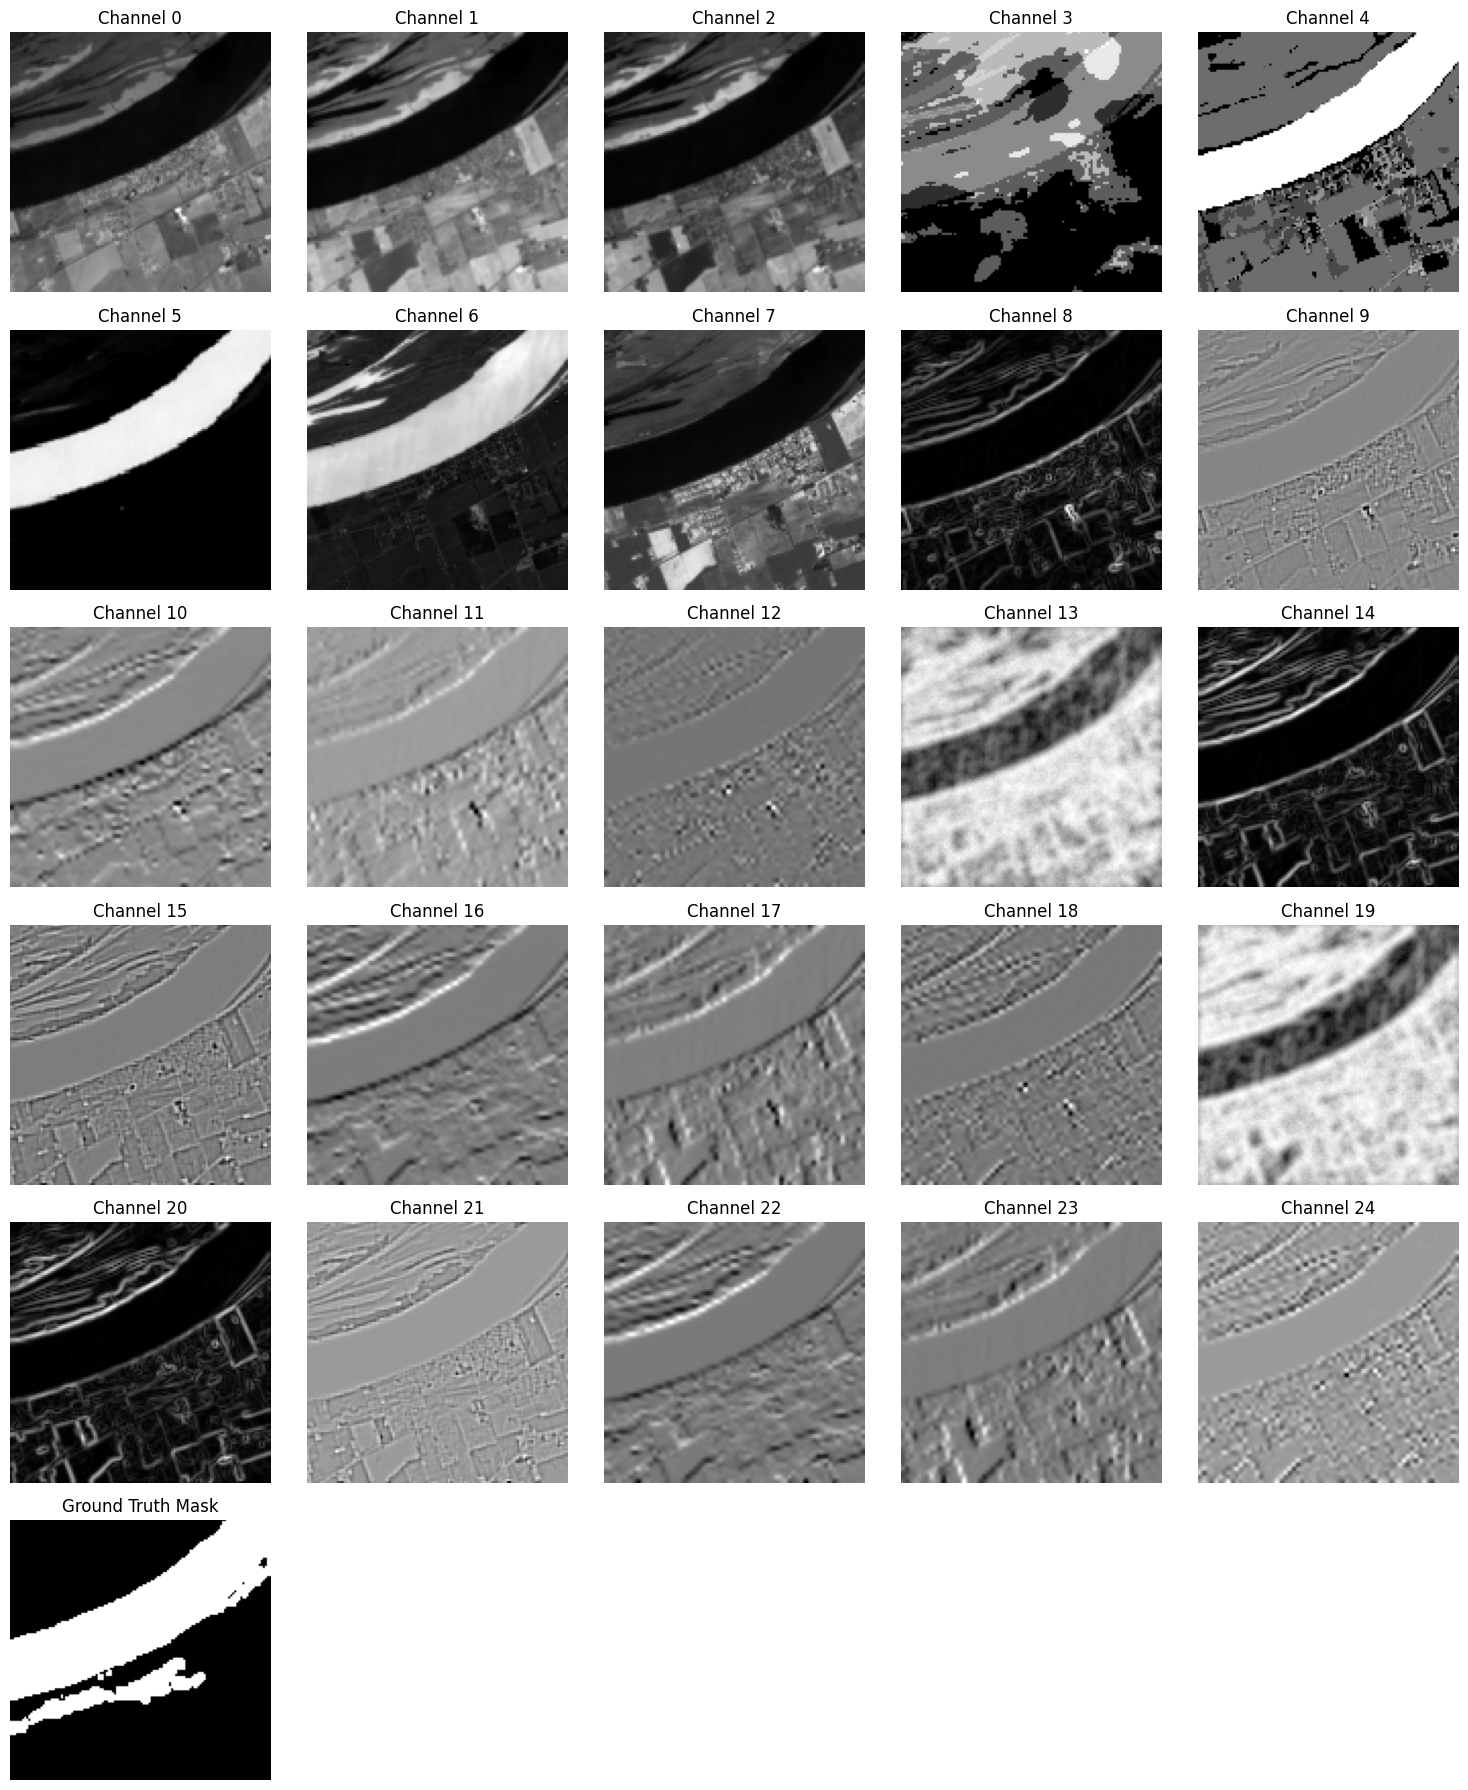

In [114]:
idx = 0  # Index within the batch
num_channels = x_batch.shape[-1]
cols = 5
rows = (num_channels + 1 + cols - 1) // cols  # +1 for the mask

plt.figure(figsize=(3 * cols, 3 * rows))

# Plot each feature channel
for i in range(num_channels):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(x_batch[idx, :, :, i], cmap='gray')
    plt.title(f"Channel {i}")
    plt.axis("off")

# Plot ground truth mask
plt.subplot(rows, cols, num_channels + 1)
plt.imshow(y_batch[idx].squeeze(), cmap='gray')
plt.title("Ground Truth Mask")
plt.axis("off")

plt.tight_layout()
plt.show()

# Modeling

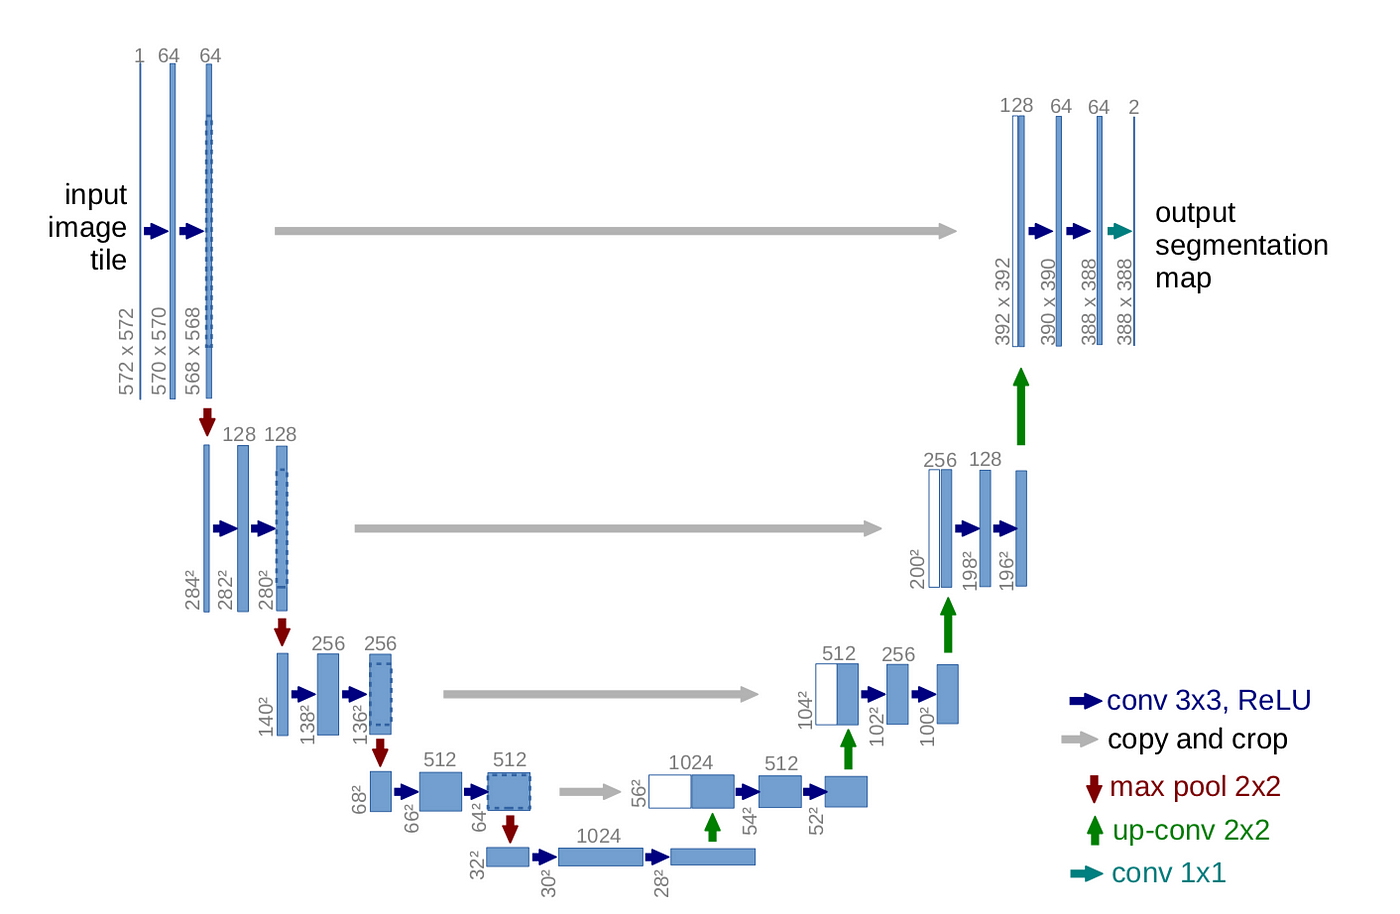

In [115]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    c1=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(inputs)
    c1=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c1)
    p1=MaxPooling2D((2,2))(c1)

    c2=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p1)
    c2=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c2)
    p2=MaxPooling2D((2,2))(c2)

    c3=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p2)
    c3=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c3)
    p3=MaxPooling2D((2,2))(c3)

    c4=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p3)
    c4=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c4)
    p4=MaxPooling2D((2,2))(c4)

    c5=Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(p4)
    c5=Conv2D(1024,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c5)
    p5=MaxPooling2D((2,2))(c5)

    u6=Conv2DTranspose(512,(2,2),strides=(2,2),padding='same')(c5)
    u6=concatenate([u6,c4])
    c6=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u6)
    c6=Conv2D(512,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c6)

    u7=Conv2DTranspose(256,(2,2),strides=(2,2),padding='same')(c6)
    u7=concatenate([u7,c3])
    c7=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u7)
    c7=Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c7)

    u8=Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(c7)
    u8=concatenate([u8,c2])
    c8=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u8)
    c8=Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c8)

    u9=Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(c8)
    u9=concatenate([u9,c1])
    c9=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(u9)
    c9=Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(c9)

    outputs=Conv2D(1,(1,1),activation='sigmoid')(c9)

    model=Model(inputs=[inputs],outputs=[outputs])

    return model

In [119]:
model=unet_model((128,128,25))
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │     14,464 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_12… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_44[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 512) │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_13… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_46[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 16, 16,    │  2,097,664 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 31,044,417 (118.43 MB)

 Trainable params: 31,044,417 (118.43 MB)

 Non-trainable params: 0 (0.00 B)

In [120]:
save_path='/content/drive/MyDrive/food_seg_model/unet1.keras'

# Compile the model
optimizer = Adam(learning_rate=1e-4)

def binary_iou(y_true, y_pred, threshold=0.5):
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.Recall(),
        tf.keras.metrics.Precision(),
        binary_iou
    ]
)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

lr_schedul = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.2,
    min_lr=1e-8
)

checkpoint = ModelCheckpoint(
    save_path,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    verbose=1
)

In [121]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    callbacks=[early_stopping, lr_schedul, checkpoint]
)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_132']
Received: inputs=Tensor(shape=(None, 128, 128, 25))
  warnings.warn(msg)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6425 - loss: 2.1794 - precision_1: 0.3485 - recall_1: 0.4022 
Epoch 1: val_loss improved from inf to 0.69773, saving model to /content/drive/MyDrive/food_seg_model/unet1.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 455s 14s/step - accuracy: 0.6439 - loss: 2.1564 - precision_1: 0.3503 - recall_1: 0.4037 - val_accuracy: 0.7344 - val_loss: 0.6977 - val_precision_1: 0.5019 - val_recall_1: 0.6484 - learning_rate: 1.0000e-04
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - accuracy: 0.7806 - loss: 0.7109 - precision_1: 0.5634 - recall_1: 0.4942 
Epoch 2: val_loss improved from 0.69773 to 0.51089, saving model to /content/drive/MyDrive/food_seg_model/unet1.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 460s 15s/step - accuracy: 0.7811 - loss: 0.7092 - precision_1: 0.5651 - recall_1: 0.4953 - val_accuracy: 0.8062 - val_loss: 0.5109 - val_precision_1: 0.6237 - val_recall_1: 0.6901 - learning_rate: 1.0000e-04
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accur

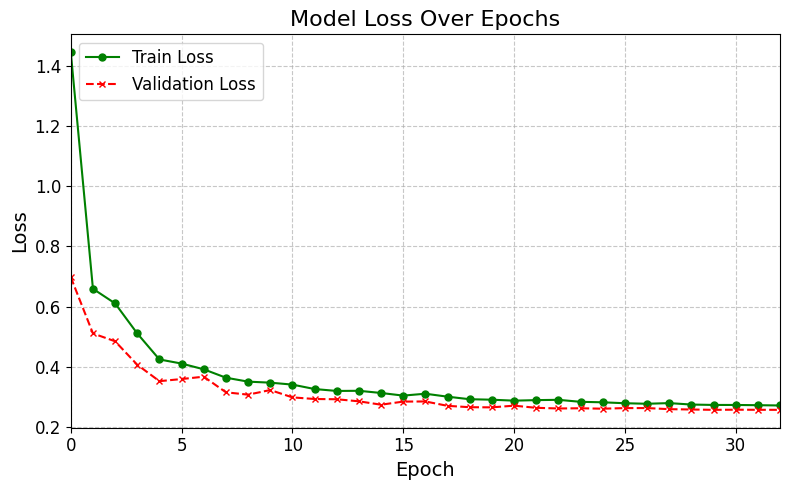

In [122]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], color='green', linestyle='-', marker='o', markersize=5, label='Train Loss')
plt.plot(history.history['val_loss'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Loss')

plt.title('Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.xlim(0, len(history.history['loss']) - 1)

plt.tight_layout()
plt.show()


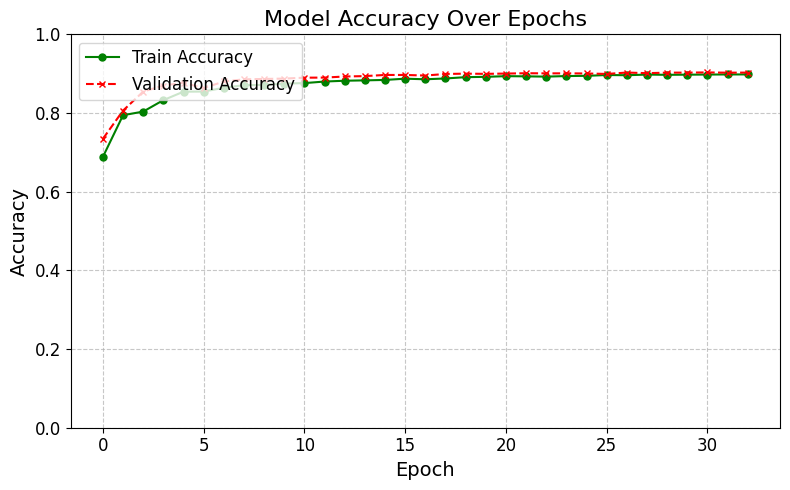

In [123]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], color='green', linestyle='-', marker='o', markersize=5, label='Train Accuracy')
plt.plot(history.history['val_accuracy'], color='red', linestyle='--', marker='x', markersize=5, label='Validation Accuracy')

plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)

plt.legend(loc='upper left', fontsize=12)

plt.ylim(0, 1)

plt.tight_layout()
plt.show()


# Load Model

In [138]:
# Load the model
loaded_model = load_model(save_path)

# Verify the model is loaded correctly (optional)
loaded_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 25)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 128, 128,  │     14,464 │ input_layer_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_38[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 64, 64,    │          0 │ conv2d_39[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_10… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_40[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 32, 32,    │          0 │ conv2d_41[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_11… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_42[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ conv2d_43[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_12… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_44[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 8, 8, 512) │          0 │ conv2d_45[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_13… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_46[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 16, 16,    │  2,097,664 │ conv2d_47[0][0]   │
│ (Conv2DTranspose)   │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 16, 16,    │          0 │ conv2d_transpose

 Total params: 93,133,253 (355.28 MB)

 Trainable params: 31,044,417 (118.43 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 62,088,836 (236.85 MB)

# Model Evaluation

In [125]:
loaded_model.evaluate(val_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 40s 4s/step - accuracy: 0.8859 - loss: 0.3024 - precision_1: 0.8294 - recall_1: 0.6655


[0.2572076618671417,
 0.9026814103126526,
 0.7478427886962891,
 0.8691964745521545]

In [126]:
predictions=loaded_model.predict(val_generator)

8/8 ━━━━━━━━━━━━━━━━━━━━ 33s 4s/step


In [133]:
img[0].shape

/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(128, 128, 25)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


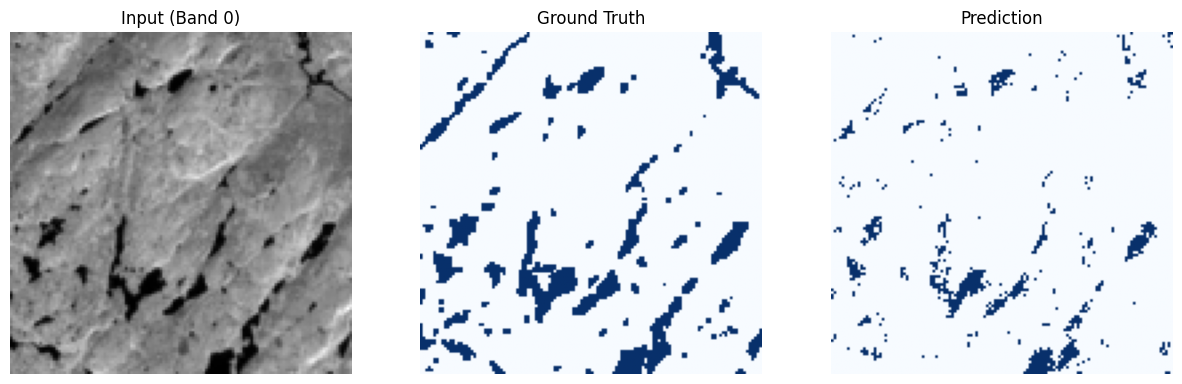

In [149]:
X_batch, y_batch = val_generator[5]

# Predict
preds = model.predict(X_batch)

# Threshold
preds_thresholded = (preds > 0.5).astype(np.uint8)

# Visualize first image in batch
i = 0
plt.figure(figsize=(15,5))

plt.subplot(1,3,1)
plt.imshow(X_batch[i][..., 0], cmap='gray')
plt.title('Input (Band 0)')
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(y_batch[i].squeeze(), cmap='Blues')
plt.title('Ground Truth')
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(preds_thresholded[i].squeeze(), cmap='Blues')
plt.title('Prediction')
plt.axis('off')

plt.show()


In [151]:
y_true_all = []
y_pred_all = []

for i in range(len(val_generator)):
    X_batch, y_batch = val_generator[i]
    preds_batch = model.predict(X_batch)

    # Flatten and threshold predictions and masks
    y_true_all.extend(y_batch.flatten())
    y_pred_all.extend((preds_batch.flatten() > 0.5).astype(np.uint8))

y_true_all = np.array(y_true_all, dtype=np.uint8)
y_pred_all = np.array(y_pred_all, dtype=np.uint8)


/usr/local/lib/python3.11/dist-packages/rasterio/__init__.py:356: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [152]:
from sklearn.metrics import classification_report

report = classification_report(y_true_all, y_pred_all, target_names=["Background", "Object"])
print(report)


              precision    recall  f1-score   support

  Background       0.91      0.96      0.94    744743
      Object       0.87      0.75      0.80    271065

    accuracy                           0.90   1015808
   macro avg       0.89      0.85      0.87   1015808
weighted avg       0.90      0.90      0.90   1015808



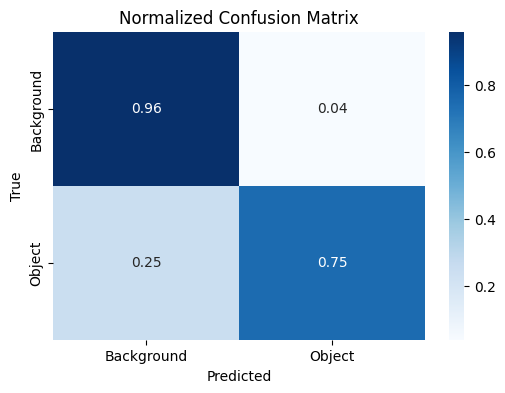

In [153]:
# Get confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all)

# Optional normalization
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6, 4))
sns.heatmap(cm_norm, annot=True, cmap="Blues", xticklabels=["Background", "Object"], yticklabels=["Background", "Object"], fmt=".2f")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix")
plt.show()
